In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import uproot
from matplotlib.patches import Patch

import sys
sys.path.append('/exp/sbnd/app/users/brindenc/analyze_sbnd/pyana')

#MY imports
from sbnd.general import plotters
from sbnd.plotlibrary import makeplot
from sbnd.stats import syst
from sbnd.cafclasses.nu import NU
from sbnd.cafclasses.slice import CAFSlice

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Variables/Constants

In [215]:
GENIE_ROOT_NAME = 'GENIEReWeight_SBN_v1_multisim_'

## 2. Load data

In [216]:
fname = '/exp/sbnd/data/users/brindenc/analyze_sbnd/numu/v09_89_01/test_fcl/test.df'

In [217]:
caf = CAFSlice.load(fname)
nu = NU.load(fname)

## 3. Single param

In [229]:
bins = np.arange(0,0.5,0.05)

weights = nu.data['GENIEReWeight_SBN_v1_multisim_FSI_N_VariationResponse'].values.T
Es = nu.data.E.values

edges, nom_hist, cv_hist, upper_hist, lower_hist, weighted_hists = syst.get_weighted_hist(Es,weights,bins)

In [230]:
Es.shape

(2,)

In [219]:
weights.shape

(100, 2)

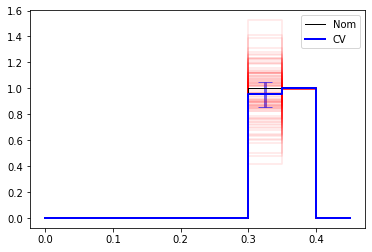

In [220]:
fig,ax = plt.subplots()
for i,hist in enumerate(weighted_hists):
    makeplot.plot_hist_edges(edges,hist,None,None,ax=ax,alpha=0.1,color='red')
makeplot.plot_hist_edges(edges,nom_hist,None,'Nom',ax=ax
        ,color='black',lw=1)
makeplot.plot_hist_edges(edges,cv_hist,[upper_hist,lower_hist],'CV',ax=ax,color='blue',lw=2)
ax.legend()

## 4. Multiple weights

In [251]:
keys = [k[0] for k in nu.data.keys()]
#weight_names = [k for k in keys if 'GENIEReWeight' in k]
weight_names = [k for k in keys if 'Flux' in k]
#get unique weight names
weight_names = list(set(weight_names))
#get number of universes for each weight
weight_lens = [len(nu.data[k].values[0]) for k in weight_names]
#assign color for each name
colors = plotters.get_colors('viridis',len(weight_names))
weight_names
#keys

['pioninexsec_Flux',
 'nucleonqexsec_Flux',
 'kzero_Flux',
 'kplus_Flux',
 'piontotxsec_Flux',
 'kminus_Flux',
 'pionqexsec_Flux',
 'piminus_Flux',
 'piplus_Flux',
 'horncurrent_Flux',
 'nucleoninexsec_Flux',
 'expskin_Flux',
 'nucleontotxsec_Flux']

In [252]:
cv_hists = [None]*len(weight_names)
upper_hists = [None]*len(weight_names)
lower_hists = [None]*len(weight_names)
weighted_hists = [None]*len(weight_names)
for i,weight_name in enumerate(weight_names):
    weights = nu.data[weight_name].values.T
    edges, nom_hist, cv_hist, upper_hist, lower_hist, weighted_hist = syst.get_weighted_hist(Es,weights,bins)
    cv_hists[i] = cv_hist
    upper_hists[i] = upper_hist
    lower_hists[i] = lower_hist
    weighted_hists[i] = weighted_hist
    
weighted_hists = np.array(weighted_hists)

In [259]:
_,cv_hist,upper_hist,lower_hist,weighted_hist = syst.combine_weighted_hists(nu,weight_names,'E',bins)

In [256]:
lower_hist,upper_hist

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.01471297, 0.01746579, 0.        ]),
 array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.01410414, 0.017174  , 0.        ]))

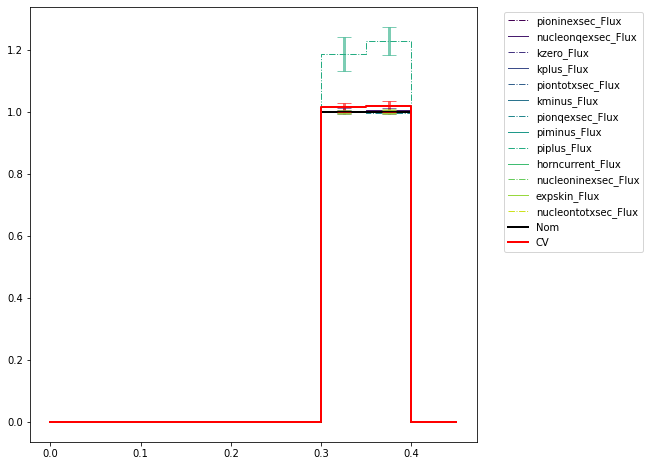

In [258]:
show_all = False
fig,ax = plt.subplots(figsize=(8,8))

for i,n in enumerate(weight_names):
    if i%2 == 0: 
        ls = '-.'
    else:
        ls = '-'
    _n = n.split(GENIE_ROOT_NAME)[-1]
    makeplot.plot_hist_edges(edges,cv_hists[i],[lower_hists[i],upper_hists[i]],_n,ax=ax
            ,color=colors[i],lw=1,linestyle=ls)
    if show_all:
        for j,hist in enumerate(weighted_hists[i]):
            makeplot.plot_hist_edges(edges,hist,None,None,ax=ax,alpha=0.05,color=colors[i])
makeplot.plot_hist_edges(edges,nom_hist,None,'Nom',ax=ax,color='k',lw=2)
makeplot.plot_hist_edges(edges,cv_hist,[lower_hist,upper_hist],ax=ax,color='red',lw=2,label='CV')

ax.legend(bbox_to_anchor=(1.05, 1))


## 5 Combine uncertainties

## 5 Combine weights - Failed
Can't multiply weights together when some are 0

In [145]:
flux_weight_names = list(set([k for k in keys if 'Flux' in k]))
genie_weight_names = list(set([k for k in keys if 'GENIE' in k]))

In [146]:
#Combine genie weights into single weight
genie_weight_name = 'GENIE'
flux_weight_name = 'Flux'



In [181]:
nuu = NU(nu)

In [182]:
def combine_weights(caf,weight_names,new_name):
    #Set up implementation of new weights
    new_names = [f'{new_name}.{k}' for k in caf.data[weight_names[0]].keys()] #get universe names
    new_cols = [caf.get_key(k)[0] for k in new_names]
   
    #Remove keys if already in df
    if caf.check_key(new_names[0]): #assume we only need to check one
        print('removing cols')
        caf.data.drop(columns=new_cols,inplace=True)
    
    #Check that each weight name has the same number of universes
    nuni_check = set([len(caf.data[w].keys()) for w in weight_names]) #collapses to a single value if they're all the same value
    assert len(nuni_check) == 1, f"Each universe must have the same number of weights in weight_names: {weight_names}"
    
    #Concatenate weights into single weights for each universe and event
    weights = np.array([caf.data[k].values.T for k in weight_names]) #W,N,E
    new_weight = np.prod(weights,axis=0) #N,E
    
    #Check for weights equal to 0
    zero_weights = new_weight == 0
    if (zero_weights).any():
        #Find index where weight is zero
        zero_weight_idx = np.array(np.where(zero_weights))
        idx_xy = [f'[{arr[0]},{arr[1]}]' for arr in zero_weight_idx.T]
        print(f'Warning: Zero weight caused {idx_xy}')
    
    #Add to data
    new_data = pd.DataFrame(new_weight.T, columns=new_cols, index=caf.data.index)
    caf.data = pd.concat([caf.data, new_data], axis=1)
    
    return caf
    

In [183]:
nuu = combine_weights(nuu,genie_weight_names,'genie')
nuu = combine_weights(nuu,flux_weight_names,'flux')

In [184]:
nuu.data.genie
nuu.data.flux

univ_0    univ_1    univ_2    univ_3    univ_4  \
entry rec.mc.nu..index                                                     
0     0                 1.355708  1.232246  1.268349  1.328756  1.165569   
      1                 1.201362  1.154138  1.250895  1.356122  1.003615   

                          univ_5    univ_6    univ_7    univ_8    univ_9  ...  \
entry rec.mc.nu..index                                                    ...   
0     0                 1.168008  1.106877  1.021251  1.211461  1.167640  ...   
      1                 1.115223  1.177749  1.194482  1.321927  1.246255  ...   

                        univ_240  univ_241  univ_242  univ_243  univ_244  \
entry rec.mc.nu..index                                                     
0     0                 1.339862  1.096387  1.184719  1.175395  1.285981   
      1                 1.261438  1.258120  1.166875  1.236869  1.306682   

                        univ_245  univ_246  univ_247  univ_248  univ_249  
entry rec.mc.nu..index                                                    
0     0                 1.182930  1.135743  1.192358  1.251545  1.223951  
      1                 1.239908  1.307677  1.279528  1.214245  1.194618  

[2 rows x 250 columns]